In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.lgb import fit_lgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "lgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-01 05:32:19.990826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 05:32:20.392508: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-01 05:32:21.928073: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_110


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:14<00:00,  1.09it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
926,21.070280,21.889490,4.451904,-20.794807,0.027129,0.014742,0.037067,477.5,0.0,68877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22235,3
927,-2.156629,17.598087,3.993946,-21.465599,0.091583,0.079287,0.072814,597.5,0.0,68997.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259,3
928,6.870979,16.874817,4.571238,-17.906569,0.048471,0.023354,0.085562,717.5,0.0,69117.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22283,3
929,11.430203,8.910088,3.756421,-5.006313,0.029496,0.013204,0.031394,837.5,0.0,69237.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22307,3
930,10.291650,2.129946,1.981583,-21.022831,0.003008,0.001954,0.058677,957.5,0.0,69357.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22331,3


(494843, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_lgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["lightgbm"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        joblib.dump(model, os.path.join(CFG["output_dir"], f'lgb_{event}_fold_{i}.pkl'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.36847	valid_0's l2: 1.87272
[200]	valid_0's rmse: 1.17982	valid_0's l2: 1.39198
[300]	valid_0's rmse: 1.13943	valid_0's l2: 1.2983
[400]	valid_0's rmse: 1.12859	valid_0's l2: 1.27372
[500]	valid_0's rmse: 1.12576	valid_0's l2: 1.26733
[600]	valid_0's rmse: 1.12452	valid_0's l2: 1.26453
[700]	valid_0's rmse: 1.12389	valid_0's l2: 1.26312
[800]	valid_0's rmse: 1.12359	valid_0's l2: 1.26245
[900]	valid_0's rmse: 1.12311	valid_0's l2: 1.26137
[1000]	valid_0's rmse: 1.12271	valid_0's l2: 1.26049
[1100]	valid_0's rmse: 1.12216	valid_0's l2: 1.25925
[1200]	valid_0's rmse: 1.12191	valid_0's l2: 1.25869
[1300]	valid_0's rmse: 1.12177	valid_0's l2: 1.25838
[1400]	valid_0's rmse: 1.12164	valid_0's l2: 1.25807


 20%|██        | 1/5 [02:42<10:50, 162.69s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.44684	valid_0's l2: 2.09335
[200]	valid_0's rmse: 1.24867	valid_0's l2: 1.55917
[300]	valid_0's rmse: 1.20464	valid_0's l2: 1.45116
[400]	valid_0's rmse: 1.19227	valid_0's l2: 1.42152
[500]	valid_0's rmse: 1.18812	valid_0's l2: 1.41164
[600]	valid_0's rmse: 1.18695	valid_0's l2: 1.40884
[700]	valid_0's rmse: 1.18664	valid_0's l2: 1.40812
[800]	valid_0's rmse: 1.18639	valid_0's l2: 1.40752
[900]	valid_0's rmse: 1.18609	valid_0's l2: 1.4068
[1000]	valid_0's rmse: 1.18608	valid_0's l2: 1.40678
[1100]	valid_0's rmse: 1.18585	valid_0's l2: 1.40625


 40%|████      | 2/5 [05:09<07:40, 153.55s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.46243	valid_0's l2: 2.1387
[200]	valid_0's rmse: 1.2755	valid_0's l2: 1.62691
[300]	valid_0's rmse: 1.23423	valid_0's l2: 1.52332
[400]	valid_0's rmse: 1.22482	valid_0's l2: 1.50018
[500]	valid_0's rmse: 1.22104	valid_0's l2: 1.49095
[600]	valid_0's rmse: 1.22031	valid_0's l2: 1.48916
[700]	valid_0's rmse: 1.21972	valid_0's l2: 1.48772
[800]	valid_0's rmse: 1.21966	valid_0's l2: 1.48756
[900]	valid_0's rmse: 1.2192	valid_0's l2: 1.48645
[1000]	valid_0's rmse: 1.21918	valid_0's l2: 1.4864
[1100]	valid_0's rmse: 1.21881	valid_0's l2: 1.48549
[1200]	valid_0's rmse: 1.21866	valid_0's l2: 1.48514
[1300]	valid_0's rmse: 1.21873	valid_0's l2: 1.48531


 60%|██████    | 3/5 [07:52<05:15, 157.92s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.36465	valid_0's l2: 1.86227
[200]	valid_0's rmse: 1.16232	valid_0's l2: 1.35099
[300]	valid_0's rmse: 1.11859	valid_0's l2: 1.25124
[400]	valid_0's rmse: 1.10768	valid_0's l2: 1.22696
[500]	valid_0's rmse: 1.10422	valid_0's l2: 1.21931
[600]	valid_0's rmse: 1.10346	valid_0's l2: 1.21763
[700]	valid_0's rmse: 1.10312	valid_0's l2: 1.21686
[800]	valid_0's rmse: 1.10295	valid_0's l2: 1.21649


 80%|████████  | 4/5 [10:05<02:27, 147.96s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.39236	valid_0's l2: 1.93867
[200]	valid_0's rmse: 1.20892	valid_0's l2: 1.46148
[300]	valid_0's rmse: 1.17171	valid_0's l2: 1.37291
[400]	valid_0's rmse: 1.16442	valid_0's l2: 1.35587
[500]	valid_0's rmse: 1.16072	valid_0's l2: 1.34728
[600]	valid_0's rmse: 1.15941	valid_0's l2: 1.34423
[700]	valid_0's rmse: 1.15881	valid_0's l2: 1.34285
[800]	valid_0's rmse: 1.15861	valid_0's l2: 1.34238
[900]	valid_0's rmse: 1.15842	valid_0's l2: 1.34194
[1000]	valid_0's rmse: 1.15824	valid_0's l2: 1.34151
[1100]	valid_0's rmse: 1.15827	valid_0's l2: 1.34159


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.38944	valid_0's l2: 1.93053
[200]	valid_0's rmse: 1.19396	valid_0's l2: 1.42555
[300]	valid_0's rmse: 1.14735	valid_0's l2: 1.31641
[400]	valid_0's rmse: 1.13526	valid_0's l2: 1.28881
[500]	valid_0's rmse: 1.13222	valid_0's l2: 1.28193
[600]	valid_0's rmse: 1.13028	valid_0's l2: 1.27753
[700]	valid_0's rmse: 1.12946	valid_0's l2: 1.27569
[800]	valid_0's rmse: 1.12899	valid_0's l2: 1.27462
[900]	valid_0's rmse: 1.12875	valid_0's l2: 1.27407
[1000]	valid_0's rmse: 1.12836	valid_0's l2: 1.27319
[1100]	valid_0's rmse: 1.12805	valid_0's l2: 1.2725
[1200]	valid_0's rmse: 1.12782	valid_0's l2: 1.27198
[1300]	valid_0's rmse: 1.12773	valid_0's l2: 1.27177
[1400]	valid_0's rmse: 1.12783	valid_0's l2: 1.27199


 20%|██        | 1/5 [02:42<10:50, 162.59s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.44614	valid_0's l2: 2.09132
[200]	valid_0's rmse: 1.23435	valid_0's l2: 1.52361
[300]	valid_0's rmse: 1.17994	valid_0's l2: 1.39227
[400]	valid_0's rmse: 1.16384	valid_0's l2: 1.35453
[500]	valid_0's rmse: 1.15864	valid_0's l2: 1.34244
[600]	valid_0's rmse: 1.1565	valid_0's l2: 1.3375
[700]	valid_0's rmse: 1.15561	valid_0's l2: 1.33544
[800]	valid_0's rmse: 1.15485	valid_0's l2: 1.33367
[900]	valid_0's rmse: 1.15432	valid_0's l2: 1.33246
[1000]	valid_0's rmse: 1.1539	valid_0's l2: 1.33148
[1100]	valid_0's rmse: 1.15366	valid_0's l2: 1.33093
[1200]	valid_0's rmse: 1.15348	valid_0's l2: 1.33051
[1300]	valid_0's rmse: 1.15321	valid_0's l2: 1.32989
[1400]	valid_0's rmse: 1.1531	valid_0's l2: 1.32965
[1500]	valid_0's rmse: 1.15282	valid_0's l2: 1.32898


 40%|████      | 2/5 [05:41<08:36, 172.21s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.43409	valid_0's l2: 2.05662
[200]	valid_0's rmse: 1.23157	valid_0's l2: 1.51677
[300]	valid_0's rmse: 1.18498	valid_0's l2: 1.40417
[400]	valid_0's rmse: 1.17155	valid_0's l2: 1.37252
[500]	valid_0's rmse: 1.16744	valid_0's l2: 1.36291
[600]	valid_0's rmse: 1.16634	valid_0's l2: 1.36034
[700]	valid_0's rmse: 1.16536	valid_0's l2: 1.35807
[800]	valid_0's rmse: 1.16456	valid_0's l2: 1.35621
[900]	valid_0's rmse: 1.1644	valid_0's l2: 1.35583
[1000]	valid_0's rmse: 1.16426	valid_0's l2: 1.35549
[1100]	valid_0's rmse: 1.16395	valid_0's l2: 1.35478
[1200]	valid_0's rmse: 1.1634	valid_0's l2: 1.3535
[1300]	valid_0's rmse: 1.16315	valid_0's l2: 1.35293
[1400]	valid_0's rmse: 1.16297	valid_0's l2: 1.3525


 60%|██████    | 3/5 [08:27<05:38, 169.38s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.42117	valid_0's l2: 2.01971
[200]	valid_0's rmse: 1.24982	valid_0's l2: 1.56204
[300]	valid_0's rmse: 1.21578	valid_0's l2: 1.47812
[400]	valid_0's rmse: 1.20792	valid_0's l2: 1.45907
[500]	valid_0's rmse: 1.20421	valid_0's l2: 1.45012
[600]	valid_0's rmse: 1.20371	valid_0's l2: 1.44892
[700]	valid_0's rmse: 1.20313	valid_0's l2: 1.44753
[800]	valid_0's rmse: 1.20289	valid_0's l2: 1.44694
[900]	valid_0's rmse: 1.2029	valid_0's l2: 1.44697


 80%|████████  | 4/5 [10:53<02:40, 160.10s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.42938	valid_0's l2: 2.04314
[200]	valid_0's rmse: 1.26129	valid_0's l2: 1.59085
[300]	valid_0's rmse: 1.22366	valid_0's l2: 1.49735
[400]	valid_0's rmse: 1.21081	valid_0's l2: 1.46606
[500]	valid_0's rmse: 1.20584	valid_0's l2: 1.45405
[600]	valid_0's rmse: 1.20455	valid_0's l2: 1.45094
[700]	valid_0's rmse: 1.20375	valid_0's l2: 1.44902
[800]	valid_0's rmse: 1.20318	valid_0's l2: 1.44764
[900]	valid_0's rmse: 1.20244	valid_0's l2: 1.44586
[1000]	valid_0's rmse: 1.20192	valid_0's l2: 1.4446
[1100]	valid_0's rmse: 1.20179	valid_0's l2: 1.44431
[1200]	valid_0's rmse: 1.20168	valid_0's l2: 1.44403
[1300]	valid_0's rmse: 1.2015	valid_0's l2: 1.44361
[1400]	valid_0's rmse: 1.2015	valid_0's l2: 1.4436


100%|██████████| 5/5 [14:05<00:00, 169.17s/it]


## Dynamic-Range NMS

<AxesSubplot: >

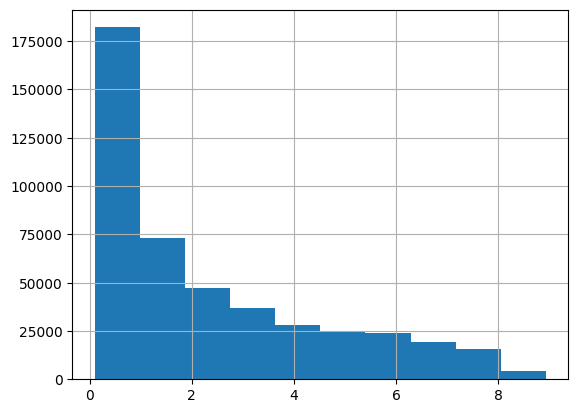

In [4]:
train = train[train["score"] > 0.1]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:10<00:00, 26.15it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7659


event   tolerance
onset   12           0.184294
        36           0.605758
        60           0.750205
        90           0.818199
        120          0.844954
        150          0.864319
        180          0.877525
        240          0.896082
        300          0.902463
        360          0.908306
wakeup  12           0.173917
        36           0.615770
        60           0.746965
        90           0.809229
        120          0.841480
        150          0.865264
        180          0.879518
        240          0.900505
        300          0.911373
        360          0.921728
dtype: float64